# MEMO Tutorial on the Qemistree Evaluation Dataset

In this tutorial, we will use the Qemistree published dataset (https://doi.org/10.1038/s41589-020-00677-3) to apply the MS2 BasEd SaMple VectOrization (MEMO) method

The dataset is constitued of 2 fecal samples, 1 tomato sample and 1 plasma sample, plus different binary/quaternary mixtures of these four samples. Samples were profiled in UHPLC-MS/MS (Q-Exactive spectrometer) using 2 different LC-methods. Each sample was acquired in triplicates using each LC-method (see Qemistree paper for details).

## First we import the needed packages
Be sure to have first installed memo using 'pip install memo' within the memo environment. 
Also make sure to launch this notebook using the memo conda environement.

In [1]:
import pandas as pd
import numpy as np
import memo_ms as memo
import plotly.express as px

C:\Users\gaudrya.FARMA\Anaconda3\envs\memo\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


With this step we import metadata:

In [2]:

def conditions(df_meta):
    if ((df_meta['Proportion_Fecal_1']>0) & (df_meta['Proportion_Fecal_2']==0)& (df_meta['Proportion_Tomato']==0) & (df_meta['Proportion_NIST_1950_SRM']==0)):
        return 'Fecal_1'
    if ((df_meta['Proportion_Fecal_1']==0) & (df_meta['Proportion_Fecal_2']>0)& (df_meta['Proportion_Tomato']==0) & (df_meta['Proportion_NIST_1950_SRM']==0)):
        return 'Fecal_2'
    if ((df_meta['Proportion_Fecal_1']==0) & (df_meta['Proportion_Fecal_2']==0)& (df_meta['Proportion_Tomato']>0) & (df_meta['Proportion_NIST_1950_SRM']==0)):
        return 'Tomato'
    if ((df_meta['Proportion_Fecal_1']==0) & (df_meta['Proportion_Fecal_2']==0)& (df_meta['Proportion_Tomato']==0) & (df_meta['Proportion_NIST_1950_SRM']>0)):
        return 'Plasma'
    if ((df_meta['Proportion_Fecal_1']>0) & (df_meta['Proportion_Fecal_2']>0)& (df_meta['Proportion_Tomato']==0) & (df_meta['Proportion_NIST_1950_SRM']==0)):
        return 'Fecal_1 + Fecal_2'
    if ((df_meta['Proportion_Fecal_1']>0) & (df_meta['Proportion_Fecal_2']==0)& (df_meta['Proportion_Tomato']>0) & (df_meta['Proportion_NIST_1950_SRM']==0)):
        return 'Fecal_1 + Tomato'
    if ((df_meta['Proportion_Fecal_1']>0) & (df_meta['Proportion_Fecal_2']==0)& (df_meta['Proportion_Tomato']==0) & (df_meta['Proportion_NIST_1950_SRM']>0)):
        return 'Fecal_1 + Plasma'
    if ((df_meta['Proportion_Fecal_1']==0) & (df_meta['Proportion_Fecal_2']>0)& (df_meta['Proportion_Tomato']>0) & (df_meta['Proportion_NIST_1950_SRM']==0)):
        return 'Fecal_2 + Tomato'
    if ((df_meta['Proportion_Fecal_1']==0) & (df_meta['Proportion_Fecal_2']>0)& (df_meta['Proportion_Tomato']==0) & (df_meta['Proportion_NIST_1950_SRM']>0)):
        return 'Fecal_2 + Plasma'
    if ((df_meta['Proportion_Fecal_1']==0) & (df_meta['Proportion_Fecal_2']==0)& (df_meta['Proportion_Tomato']>0) & (df_meta['Proportion_NIST_1950_SRM']>0)):
        return 'Tomato + Plasma'
    if ((df_meta['Proportion_Fecal_1']>0) & (df_meta['Proportion_Fecal_2']>0)& (df_meta['Proportion_Tomato']>0) & (df_meta['Proportion_NIST_1950_SRM']>0)):
        return 'Fecal_1 + Fecal_2 + Tomato + Plasma' 
    else:
        return 'What is it? :)'


df_meta = pd.read_csv("data/1901_gradient_benchmarking_dataset_v4_sample_metadata.txt", sep='\t')
df_meta['Samplename'] = df_meta['Samplename'].str[:-6]
df_meta['Samplename'] = df_meta['Samplename'].str.replace('BLANK_', 'BLANK')
df_meta = df_meta[['Filename', 'Experiment', 'Samplename', 'Triplicate_number', 'Proportion_Fecal_1', 'Proportion_Fecal_2', 'Proportion_Tomato', 'Proportion_NIST_1950_SRM']]
df_meta['contains'] = df_meta.apply(conditions, axis=1)
df_meta['instrument'] = np.where(df_meta['Samplename'].str.contains('qTOF'), 'qTOF', 'QE')
df_meta['blank_qc'] = np.where(df_meta['Samplename'].str.contains('blank|qcmix', case = False), 'yes', 'no')
df_meta


,Filename,Experiment,Samplename,Triplicate_number,Proportion_Fecal_1,Proportion_Fecal_2,Proportion_Tomato,Proportion_NIST_1950_SRM,contains,instrument,blank_qc
0,QEC18_Blank_resusp_20181226235330.mzML,C18,QE_C18_BLANK,1,0,0,0,0,What is it? :),QE,yes
1,QEC18_Blank_resusp_20181227024429.mzML,C18,QE_C18_BLANK,2,0,0,0,0,What is it? :),QE,yes
2,QEC18_Blank_resusp_20181227051626.mzML,C18,QE_C18_BLANK,3,0,0,0,0,What is it? :),QE,yes
3,QEC18_Blank_resusp_20181227072924.mzML,C18,QE_C18_BLANK,4,0,0,0,0,What is it? :),QE,yes
4,QEC18_Blank_resusp_20181227100129.mzML,C18,QE_C18_BLANK,5,0,0,0,0,What is it? :),QE,yes
...,...,...,...,...,...,...,...,...,...,...,...
565,C18_F1-3_To-1_GC5_01_19577.mzML,C18-RTshift,qTOF_C18-RTshift_F1-3_To-1,2,75,0,25,0,Fecal_1 + Tomato,qTOF,no
566,C18_F1-3_To-1_GC5_01_19584.mzML,C18-RTshift,qTOF_C18-RTshift_F1-3_To-1,3,75,0,25,0,Fecal_1 + Tomato,qTOF,no
567,C18_F1-3_F2-1_GB4_01_19512.mzML,C18-RTshift,qTOF_C18-RTshift_F1-3_F2-1,1,75,25,0,0,Fecal_1 + Fecal_2,qTOF,no
568,C18_F1-3_F2-1_GB4_01_19547.mzML,C18-RTshift,qTOF_C18-RTshift_F1-3_F2-1,2,75,25,0,0,Fecal_1 + Fecal_2,qTOF,no


## Import feature_quant table
To compute the MEMO matrix of the dataset, we need the table reporting presence/absence of each metabolite in each sample. This information is in the quant table and we use the import_mzmine2_quant_table function to import and format it

In [3]:
quant = memo.import_mzmine2_quant_table("data/quantification_table-00000.csv")
quant

,QEC18_Blank_resusp_20181227024429.mzML,QEC18_Blank_resusp_20181227200515.mzML,QEC18_Blank_resusp_20181227180406.mzML,QEC18_Blank_resusp_20181227100129.mzML,QEC18_Blank_resusp_20181226235330.mzML,QEC18_Blank_resusp_20181227154841.mzML,QEC18_Blank_resusp_20181227072924.mzML,QEC18_Blank_resusp_20181227235313.mzML,QEC18_Blank_resusp_20181227051626.mzML,QEC18_F1-1_F2-1.mzML,...,QEC18RT_To_20181229050805.mzML,QEC18RT_QCmix_no_exclusion.mzML,QEC18RT_F2.mzML,QEC18RT_To_20181229074015.mzML,QEC18RT_Qcmix_end.mzML,QEC18RT_F1.mzML,QEC18RT_F1_20181229114729.mzML,QEC18RT_F2_20181229083715.mzML,QEC18RT_F2_20181228211241.mzML,QEC18RT_F1_20181228113615.mzML
row ID,,,,,,,,,,,,,,,,,,,,,
1,8.739521e+08,1.205125e+09,8.856410e+08,1.672233e+09,3.730564e+08,1.694707e+09,1.250287e+09,1.174462e+09,1.250107e+09,2.233406e+08,...,329089.838818,5.834382e+05,1.125321e+06,1.761620e+06,4.494813e+05,2.651802e+05,5.304884e+05,4.728289e+05,5.962238e+05,5.971862e+05
2,1.481579e+08,3.421555e+08,2.189828e+08,3.215060e+08,1.466751e+08,3.779046e+08,2.547772e+08,3.116616e+08,2.454641e+08,1.667905e+07,...,430302.125590,4.218561e+05,2.769745e+05,4.475155e+05,3.973298e+05,5.065530e+05,2.502201e+05,1.238884e+05,1.094719e+05,2.389570e+05
3,9.837010e+07,2.866821e+07,1.133203e+08,2.621886e+08,4.948088e+07,3.325100e+06,1.912927e+08,2.064894e+08,1.669947e+08,3.245482e+06,...,581.722337,0.000000e+00,0.000000e+00,7.836569e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
4,8.224197e+07,8.136892e+07,1.442344e+08,2.304763e+08,0.000000e+00,2.873334e+07,2.817894e+08,0.000000e+00,1.024043e+08,0.000000e+00,...,258414.856693,0.000000e+00,2.111572e+05,2.359778e+05,1.748818e+04,4.924721e+05,8.183989e+03,4.191255e+04,0.000000e+00,5.393931e+05
5,7.315887e+07,7.267058e+07,2.595832e+08,0.000000e+00,2.946699e+08,4.263457e+08,1.223111e+07,1.622914e+08,1.737644e+08,1.116640e+08,...,505079.412864,3.919205e+05,6.063203e+05,6.117475e+05,1.080398e+06,2.399147e+05,8.817621e+05,1.300201e+05,2.797098e+05,2.718625e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7028,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000,1.176028e+06,4.565675e+06,0.000000e+00,1.620638e+06,4.512574e+06,6.209425e+05,4.468508e+06,5.771853e+05,6.262678e+06
7029,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.416685e+04,...,0.000000,4.439594e+06,1.200933e+06,0.000000e+00,4.475984e+06,1.276397e+07,6.744892e+06,0.000000e+00,4.531521e+06,1.224795e+06
7030,7.638457e+03,2.869926e+03,5.820253e+03,2.094878e+03,6.407866e+03,3.131129e+03,4.183935e+03,4.523492e+03,2.258435e+03,3.047024e+03,...,0.000000,4.274993e+06,1.031305e+07,9.990865e+03,4.003327e+06,8.826358e+06,6.012722e+06,9.674889e+06,1.059177e+07,5.639867e+06


## Import spectra
Since MEMO relies on the occurence of MS2 fragments/losses in samples to compare them, we obviously need to importthe features' fragmentation spectra. This is what is done here using load_and_filter_from_mgf function. 


In [4]:
spec = memo.load_and_filter_from_mgf("data/qemistree_specs_ms.mgf", min_relative_intensity = 0.01)
len(spec)

5826

## From spectra to documents

This step allows to get the documents (ie peaks and losses) from each spectra we previsouly loaded

In [5]:
doc = memo.spec2doc(spec)
doc

,scans,pepmass,charge,collision_energy,documents
0,1,"(338.342, None)",[1+],0.0,"[peak@71.05, peak@71.09, peak@72.08, peak@78.7..."
1,2,"(278.1905, None)",[1+],0.0,"[peak@84.08, peak@91.05, peak@105.07, peak@115..."
2,3,"(702.2131, None)",[1+],0.0,"[peak@73.05, peak@79.02, peak@80.97, peak@81.0..."
3,4,"(663.452, None)",[1+],0.0,"[peak@91.05, peak@147.12, peak@251.05, peak@30..."
4,5,"(663.4555, None)",[1+],0.0,"[peak@91.05, peak@147.12, peak@251.05, peak@30..."
...,...,...,...,...,...
5821,7028,"(381.3165, None)",[1+],0.0,"[peak@70.07, peak@71.05, peak@71.09, peak@72.3..."
5822,7029,"(453.3377, None)",[1+],0.0,"[peak@71.05, peak@79.05, peak@81.03, peak@81.0..."
5823,7030,"(165.0911, None)",[1+],0.0,"[peak@81.07, peak@83.05, peak@91.05, peak@95.0..."
5824,7031,"(501.3573, None)",[1+],0.0,"[peak@81.07, peak@95.09, peak@105.07, peak@198..."


## Generation of MEMO matrix

Using the generated documents and the quant table, we can now obtain the MEMO matrix

In [6]:
memo_matrix = memo.generate_memo(doc, quant)
memo_matrix

,peak@71.05,peak@71.09,peak@72.08,peak@78.74,peak@79.05,peak@81.07,peak@83.09,peak@85.10,peak@86.06,peak@86.10,...,peak@604.26,peak@620.26,peak@679.27,peak@131.23,peak@138.34,peak@177.88,peak@235.22,peak@262.41,peak@345.96,peak@444.82
QEC18_Blank_resusp_20181227024429.mzML,749,1245,77,2,1802,2261,1887,864,61,261,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
QEC18_Blank_resusp_20181227200515.mzML,734,1215,71,3,1775,2285,1846,836,58,265,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
QEC18_Blank_resusp_20181227180406.mzML,774,1297,75,3,1968,2477,2008,899,59,271,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
QEC18_Blank_resusp_20181227100129.mzML,771,1303,74,3,1926,2474,2001,900,60,267,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
QEC18_Blank_resusp_20181226235330.mzML,707,1187,72,2,1688,2115,1768,820,60,249,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
QEC18RT_F1.mzML,950,1668,118,1,2694,3544,2837,1093,69,387,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
QEC18RT_F1_20181229114729.mzML,957,1668,114,2,2700,3553,2849,1082,69,404,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
QEC18RT_F2_20181229083715.mzML,858,1584,114,1,2540,3389,2711,1032,70,386,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
QEC18RT_F2_20181228211241.mzML,860,1588,112,1,2563,3402,2737,1035,70,380,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Filter MEMO matrix

This step allows to filter peaks and losses occuring in blank samples AND to remove blanks samples from the MEMO matrix. In the case of the Qemistree dataset, we just use it to remove the blanks samples

In [7]:
memo_matrix_filtered = memo.filter_memo(memo_matrix, 'blank', 100)
memo_matrix_filtered

,peak@71.05,peak@71.09,peak@72.08,peak@78.74,peak@79.05,peak@81.07,peak@83.09,peak@85.10,peak@86.06,peak@86.10,...,peak@604.26,peak@620.26,peak@679.27,peak@131.23,peak@138.34,peak@177.88,peak@235.22,peak@262.41,peak@345.96,peak@444.82
QEC18_F1-1_F2-1.mzML,897,1577,107,2,2553,3364,2695,1040,73,366,...,0,0,0,0,0,0,0,0,0,0
QEC18_F1-1_NIST-3.mzML,875,1566,103,2,2505,3330,2643,1029,72,387,...,0,0,0,0,0,0,0,0,0,0
QEC18_F1-1_F2-1_20181227143118.mzML,900,1611,113,1,2598,3474,2743,1051,70,392,...,0,0,0,0,0,0,0,0,0,0
QEC18_F1-1_F2-1_20181227084526.mzML,915,1635,109,3,2653,3532,2793,1064,71,390,...,0,0,0,0,0,0,0,0,0,0
QEC18_F1-1_F2-1_NIST-2_To-1.mzML,1002,1671,110,3,2991,3913,2961,1087,70,460,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
QEC18RT_F1.mzML,950,1668,118,1,2694,3544,2837,1093,69,387,...,0,0,0,0,0,0,0,0,0,0
QEC18RT_F1_20181229114729.mzML,957,1668,114,2,2700,3553,2849,1082,69,404,...,0,0,0,0,0,0,0,0,0,0
QEC18RT_F2_20181229083715.mzML,858,1584,114,1,2540,3389,2711,1032,70,386,...,0,0,0,0,0,0,0,0,0,0
QEC18RT_F2_20181228211241.mzML,860,1588,112,1,2563,3402,2737,1035,70,380,...,0,0,0,0,0,0,0,0,0,0


## Plotting

We can now use the MEMO matrix to generate the PCoA of our samples

In [8]:

plot = memo.plot_pcoa_2d(
    memo_matrix=memo_matrix_filtered,
    df_metadata=df_meta,
    metric= 'braycurtis',
    filename_col = 'Filename',
    color='contains',
    norm = False,
    scaling= False,
    pc_to_plot = [1,2]
)

C:\Users\gaudrya.FARMA\Anaconda3\envs\memo\lib\site-packages\skbio\stats\ordination\_principal_coordinate_analysis.py:143: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.019614578699025866 and the largest is 0.521040583145881.
  warn(


In [9]:
df_meta_sub = df_meta[(df_meta['Triplicate_number'] == 2)&(df_meta['Experiment'] == 'C18')]

In [10]:
plot = memo.plot_heatmap(
    memo_matrix=memo_matrix_filtered,
    df_metadata=df_meta_sub,
    filename_col = 'Filename',
    label_col = 'contains',
    plotly_discrete_cm = px.colors.qualitative.Plotly,
    linkage_method='ward',
    linkage_metric = 'euclidean',
    heatmap_metric = 'braycurtis',
    norm = False,
    scaling= False
)

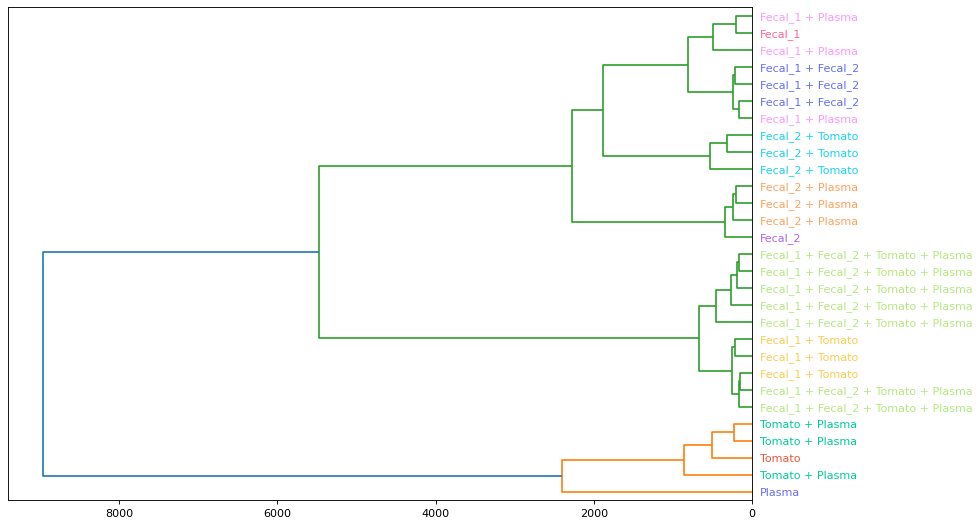

In [14]:
memo.plot_hca(
    memo_matrix=memo_matrix_filtered,
    df_metadata=df_meta_sub,
    filename_col = 'Filename',
    label_col = 'contains',
    plotly_discrete_cm = px.colors.qualitative.Plotly,
    linkage_method='ward',
    linkage_metric = 'euclidean',
    norm = False,
    scaling= False
)